# Removing Boilerplates by Bigram

Since there are a lot of meaningless sentences ('thank you', 'no no')  in the corpus, the notebook removes them using bigram and perplexity. Sentences are removed if the perplexity score is small.

In [3]:
import numpy as np
import pandas as pd
import nltk
import re
from nltk.util import ngrams
import glob
from nltk import sent_tokenize

In [4]:
# Reading in all transcripts
corpus = ''
for filepath in glob.glob('cleaned_transcript_data/*'):
    #filepath = 'cleaned_transcript_data/cleaned_transcript_d20061129.csv'
    scripts = pd.read_csv(filepath).drop(columns ='Unnamed: 0')['Script']
    transcript = ' '.join(list(scripts))
    corpus += transcript + ' '

In [5]:
# lower case and remove non-word letters  
def clean_transcript(transcript):
    transcript = transcript.lower()
    transcript = re.sub(r'[^a-zA-Z0-9\s]', ' ', transcript)
    return transcript

In [6]:
s = corpus
s = clean_transcript(s)
words = [token for token in s.split(" ") if token != ""]
#output = list(ngrams(tokens, 3))

In [7]:
cfreq_debate_2gram = nltk.ConditionalFreqDist(nltk.bigrams(words))

In [8]:
cprob_debate_2gram = nltk.ConditionalProbDist(cfreq_debate_2gram, nltk.MLEProbDist)

In [9]:
# Calculate perplexity score given a sentence and a bigram model
def sentence_perplexity(sentence, model):
    smooth_term = 0.01
    sentence = sentence.split()
    perplexity = 1
    N = 0
    for i in range(len(sentence) - 1):
        N += 1
        try:
            prob = model[sentence[i]].prob(sentence[i+1]) + smooth_term
        except:
            prob = smooth_term
        perplexity = perplexity * (1/prob)
    if N == 0:
        return perplexity
    perplexity = pow(perplexity, 1/float(N)) 
    return perplexity

In [10]:
cprob_debate_2gram['my']

<MLEProbDist based on 3814 samples>

### Calculate Perplexity of each Sentence

In [11]:
corpus_sentences = sent_tokenize(corpus)

In [12]:
# perplexity for each sentence
idx2perplexity = dict()
for i in range(len(corpus_sentences)):
    t = clean_transcript(corpus_sentences[i])
    if len(t.split()) <= 1:
        continue
    ppl = sentence_perplexity(t, cprob_debate_2gram)
    idx2perplexity[i] = ppl

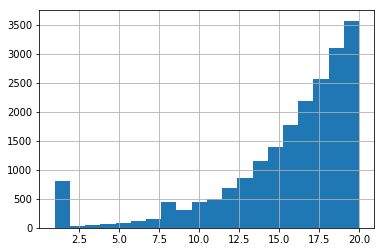

In [29]:
ppls = pd.Series(list(idx2perplexity.values()))
ppls[ppls < 20].hist(bins = 20)

In [13]:
perplexity2idx = dict(zip(idx2perplexity.values(), idx2perplexity.keys()))

In [14]:
# Take a look at 20 sentences with lowest perplexity scores
ppls_sorted = ppls.sort_values()
i = 0
boilerplates = []
bps = []
bp_ppls = []
while len(boilerplates) < 20:
    bp = corpus_sentences[perplexity2idx[ppls_sorted.iloc[i]]]
    if ppls_sorted.iloc[i] >= 2.5:
        continue
    if bp not in boilerplates:
        bps.append(bp)
        bp_ppls.append(ppls_sorted.iloc[i])
        boilerplates.append(bp)
    i += 1

In [15]:
pd.DataFrame({'Boilerplate':bps, 'Perplexity':bp_ppls})

,Boilerplate,Perplexity
0,Deward Mukendi .,0.990099
1,Barack Obama.,1.005295
2,Thank you.,1.050635
3,Et cetera.,1.054870
4,Ph.D.,1.075269
5,Mm-hmm.,1.153213
6,Goldman Sachs.,1.212393
7,"Whoah, whoah, whoah, whoah, whoah.",1.234568
8,Saudi Arabia.,1.256081
9,Forgive me.,1.269394


###  Determining a Threshold

In [201]:
ser = ppls_sorted[ppls_sorted<2.5].sort_values(ascending = False).apply(lambda x: corpus_sentences[perplexity2idx[x]])
ser.to_frame().drop_duplicates()

,0
87035,Scrap it.
13946,Shannon Brownlee: Thank you.
11091,"Yep, thank you."
56307,Simpson Bowles.
29732,Douglas Holtz-Eakin.
56390,Visualize that.
6299,"Belgium, Bolivia, Burkina Faso, Bangladesh?"
68474,Ma'am?
40236,Jo hn Donvan: Thank you.
36090,88 percent.


In [202]:
for i in idx2perplexity:
    ppl = idx2perplexity[i]
    if  ppl < 6.5 and 20 > len(corpus_sentences[i].split()) > 3:
        print(corpus_sentences[i], ppl)

And I don’t think that. 6.346814283091378
Greg Lukianoff : No . 3.9815439102225074
Whole hillsides sloughed off. 4.365947672137493
I don't think that. 5.525853127809007
Barbarossa wouldn't have happened. 5.308583262891634
Scanners don't do it. 4.219676372272734
Belgium, Bolivia, Burkina Faso, Bangladesh? 1.9202399328269013
We don't have to . 6.103302745512798
Shannon Brownlee: Thank you. 2.431335246871648
Trying to racialize affirmative action? 3.314750685096962
Giddy yap baby, giddy yap. 3.6363079957826026
Thank you, thank you. 4.0519241287543695
Jessica Grose : Right. 4.840335830958791
Bob Rosenkranz, thank you. 6.080091601424573
I don't think that. 5.525853127809007
John Donvan:Thank you, Gray Davis. 5.823668473504558
John Donvan:Thank you, Kathleen Newland. 5.7883816065615665
John Donvan:Thank you, Bryan Caplan. 5.522281338807992
Talk about unintended consequences. 5.190895763490997
From the United States. 5.1468225467257644
Jaron Lanier Yeah . 4.19285889747781
Whoah, whoah, whoah,

In [221]:
for i in idx2perplexity:
    ppl = idx2perplexity[i]
    if  7 < ppl < 8 and 20 > len(corpus_sentences[i].split()) > 3:
        print(corpus_sentences[i], ppl)

Thank you very much. 7.985290740427899
That’s what we ’re talking about. 7.207030128078247
That’s what we’re talking about. 7.207030128078247
Thank you very much. 7.985290740427899
We don’t want to do that. 7.021055113314213
Thank you very much. 7.985290740427899
Thank you very much. 7.985290740427899
Thank you very much. 7.985290740427899
Thank you very much. 7.985290740427899
Thank you very much. 7.985290740427899
Thank you very much. 7.985290740427899
I think it is. 7.949666630130362
Thank you very much. 7.985290740427899
Thank you very much. 7.985290740427899
Thank you very much. 7.985290740427899
Thank you very much. 7.985290740427899
Thank you very much. 7.985290740427899
Right now -- You don't have to. 7.87168701405241
Thank you very much. 7.985290740427899
Thank you very much. 7.985290740427899
Thank you very much. 7.985290740427899
Thank you very much. 7.985290740427899
Thank you very much. 7.985290740427899
Lucretia Dominguez was one of those people. 7.4010129406099345
Thank 

### Removing Boilerplates from Transcripts

In [13]:
def merge_for_against(cleaned):
    new_sides = []
    new_scripts = []
    new_rounds = []
    last_side = 0
    last_round = 0
    for i in range(len(cleaned)):
        side = cleaned['side'][i]
        script = cleaned['script'][i]
        round_ = str(cleaned['round'][i]).strip()
        if len(script.strip()) == 0:
            continue
        if side == last_side and round_ == last_round :
            new_scripts[-1] = new_scripts[-1] + ' ' + script
        else:
            new_sides.append(side)
            new_scripts.append(script)
            new_rounds.append(round_)
            last_side = side
            last_round = round_
    return pd.DataFrame(data = {'side': new_sides, 'script': new_scripts, 'round': new_rounds})

In [14]:
def remove_bp_script(script, model, thre):
    sents = sent_tokenize(script)
    for i in range(len(sents)):
        if sentence_perplexity(clean_transcript(sents[i]), model) < thre:
            #print(sents[i])
            sents[i] = ''
    return ' '.join(sents)

In [253]:
df = pd.read_csv('For Against Scripts/for_against_scripts_d20081007.csv')
df['script'] = df['script'].apply(lambda x: remove_bp_script(x, cprob_debate_2gram, thre = 8))
df

,side,script


In [15]:
for filepath in glob.glob('For Against Scripts/*'):
    if 'bp_free' in filepath:
        continue
    scripts = pd.read_csv(filepath)        
    scripts['script'] = scripts['script'].apply(lambda x: remove_bp_script(x, cprob_debate_2gram, thre = 8))
    fp = filepath.replace('d20', 'bp_free_d20')
    if len(scripts) == 0:
        scripts.to_csv(index = False)
        continue
    merge_for_against(scripts).to_csv(fp, index = False)

## Trigram

In [153]:
trigrams = nltk.trigrams(words)
condition_pairs = (((w0, w1), w2) for w0, w1, w2 in trigrams)
cfreq_debate_3gram = nltk.ConditionalFreqDist(condition_pairs)

In [155]:
cprob_debate_3gram = nltk.ConditionalProbDist(cfreq_debate_3gram, nltk.MLEProbDist)

In [157]:
cprob_debate_3gram[('thank', 'you')].prob('very')

0.1626733921815889

In [176]:
# Calculate perplexity score given a sentence and a bigram model
def sentence_perplexity_trigram(sentence, model):
    smooth_term = 0.1
    sentence = sentence.split()
    perplexity = 1
    N = 0
    for i in range(len(sentence) - 2):
        N += 1
        try:
            prob = model[(sentence[i], sentence[i+1])].prob(sentence[i+2]) + smooth_term
        except:
            prob = smooth_term
        perplexity = perplexity * (1/prob)
    if N == 0:
        return perplexity
    perplexity = pow(perplexity, 1/float(N)) 
    return perplexity

In [177]:
# perplexity for each sentence
idx2perplexity_3 = dict()
for i in range(len(corpus_sentences)):
    t = clean_transcript(corpus_sentences[i])
    if len(t.split()) <= 1:
        continue
    ppl = sentence_perplexity_trigram(t, cprob_debate_3gram)
    idx2perplexity_3[i] = ppl

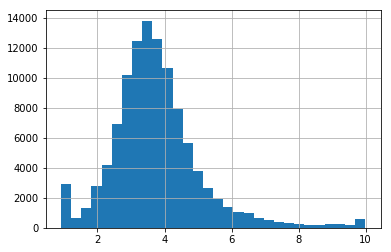

In [178]:
ppls_3 = pd.Series(list(idx2perplexity_3.values()))
ppls_3[ppls_3 < 20].hist(bins = 30)

In [179]:
for i in idx2perplexity_3:
    ppl = idx2perplexity_3[i]
    if  ppl < 1 and 20 > len(corpus_sentences[i].split()) > 3:
        print(corpus_sentences[i], ppl)

From 1945 to 1960, it doubled. 0.9090909090909091
I count many among my friends. 0.9090909090909091
This simplyis not so . 0.9090909090909091
But guess what ? 0.9090909090909091
Whole hillsides sloughed off. 0.9090909090909091
Than k you very much. 0.9163747681071077
Coal costs -- Thank you. 0.9090909090909091
We socialized the losses. 0.9090909090909091
This distrust was earned. 0.9090909090909091
How parochial is this? 0.9090909090909091
Pakistani, Yemeni, Jordanian, Egyptian, Iraqi, Lebanese, Palestinian origin. 0.9090909090909091
Bought his ticket with cash. 0.9090909090909091
So passengers hear that. 0.9090909090909091
Belgium, Bolivia, Burkina Faso, Bangladesh? 0.9090909090909091
Boot, Mandelbaum and Murray. 0.9090909090909091
How romantic is that? 0.9090909090909091
His smile is weird. 0.9090909090909091
Patents expire, prices plummet. 0.9090909090909091
Big dangerous oil, 8 percent. 0.9090909090909091
Zeke said -- No. 0.9090909090909091
The dictum is: Meum dictum pactum. 0.9090

Trigram doesn't really help.